# Stock Analysis


In [2]:
import requests

import pandas as pd
import time
import numpy as np

import datetime
import seaborn as sns

import matplotlib.pyplot as plt


import math

from alpha_vantage.timeseries import TimeSeries

In [ ]:
conda update -- all

# Introduction

Accurately predicting the stock markets is a complex task as there are millions of events and pre-conditions for a particular stock to move in a particular direction. Capturing as many pre-conditions as possible is essential. We also need to make several important assumptions:
1. markets are not 100% random
2. history repeats 
3. markets follow people's rational behavior

I will first try to predict the price movements of Starbucks (SBUX). For the purpose I will use daily closing price from April 1, 2010 to present date (April 16,2020).

# The Data

I need to understand what affects whether SBUX's stock price will up or down. It is what people think as a whole. Hence, I need to include as much information as possible. I will use 3,667 days in total - 2566 days (70%) for training and 1101 days (30%) for the test. Then I will compare the predicted results with a test (hold-out) data. Each type of data (referred to as features) is explained in greater detail in later sections, but as a high level overview, the feautres I will use are:
1. **Correlated Assets** - these are other assets (any type, not necessarily stocks, such as commodities, FX, indices, or even fixed income securities). A big compnay, such as Starbucks, obviously doesn't live in an isolated world- it depends on and interacts with many external factors, including its competitors, clients, the global economy, geo-political situation, fiscal and monetary policy, access to capital, etc.

2. **Technical Indicators** - a lot of investors follow technical indicators. We will include the most popular indicators as independant feautres. Among them: 8 and 21 day moving average, exponential moving average, momentum, Bollinger bands, MACD.

3. **Fundamental Analysis** - An important feature indicating whethera stock might move up or down. There are two features that can be used in fundamental analysis:

    1. Analysing the company performance using 10-K adn 10-Q reports, analysing ROE and P/E, etc
    2. News- potentially news can indicate upcoming events that can potentially move the stock in certain directions. I will read all daily news for Starbucks and extract whether the total sentiment about Starbucks on that day is positive, neutral, negative (as a score from 0 to 1). As many investors closely read the news and make investment decisions based partially on news, there is a somewhat high chance that if, say, the news for Starbucks today are extremely positive the stock will surge tomorrow. *One crucial point, we will perform feature importance (meaning how indicative it is for the movement of SBUX) on absolutely every feature later on and decide whether we will use it*
    For the purpose of creating accurate setniment prediction we will use Neural Language Processing (NLP). We will use *BERT*, Google's recently announced NLP approach for transfer learning for sentiment classification stock news sentiment extraction. 
    
4. **Fourier Transforms** - Along with daily closing price, we will create Fourier Transforms in order to generalize several long and short term trends. Using these transforms I will eliminate a lot of noise (random walks) and create approximations of the real stock movement. Having trend approximationscan help the LSTM network pick its prediction trends more accurately. 

5. **Autoregressive Integrated Moving Average**(ARIMA) - This was the most popular technique for predicting future values of time series data (in the pre-neural networks ages). I will add it and see if it comes off as an important predictive feature. 

6. **Stack Autoencoders** - most of the aforementioned feautres (fundamental analysis, technical analysis, etc) were found by people after decades of research. But maybe I have missed something. Maybe there are hidden correlations that people cannot comprehend due to the enormous amount of data points, events, assets, charts, etc. With stacked autoencoders (type of neural networks) I can use the power of computers and probably find new types of features that affect stock movements. Even though I will not be able to understand these features in human language, I will use them in the GAN. 

7. **Deep Unsupervised Learning for Anomaly Detection in Options Pricing** - I will use one more feature for every day we will add the price for 90-days call option on Starbucks stock. Options pricing itself combines a lot of data. The price for options contract depends on the future value of the stock (analysts try to also predict the price in order to come up with the most accurate price for the call option). Using deep unsupervised learning (*Self-Organized Maps*) we will try to spot anomalies in every day's pricing. Anomaly (such as drastic changes in pricing) might indicate an event that might be useful for the LSTM to learn the overall stock pattern. 

Having so many features:
1. Perform statistical checks for the quality of the data. If the data we create is flawed, then no matter how sophisticated our algorithms, the results will not be positive. The checks include making sure the data deos not suffer from *heteroskedasticity*, *multicollinearity*, or *serial correlation*. 
2. Create feature importance. If a feature has no explanatory power to the stock we want to predict, then there is no need for us to use it in the training of neural nets. I will use **XGBoost** (eXtreme Gradient Boosting), a type of boosted tree regression algorithms. 

As a final step of data preparation, Iwill also create **Eigen Portfolios** using Principal Component Analysis (PCA) in order to reduce the dimensionality of the feautres created from the autoencoders. 


#obtain the starbucks data for the time period
API_key= api_key

ts=TimeSeries(key=API_key,output_format='pandas')

data_csv,meta_data=ts.get_daily(symbol='SBUX',outputsize='full')

#convert data to csv
data_csv.to_csv('SBUX_Stock.csv',encoding='utf-8',index=True)

In [ ]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [3]:
#load in the SBUX data

SBUX= pd.read_csv("D:\DataFrames\Stocks\SBUX_Stock.csv")

NameError: name 'value' is not defined

In [18]:
SBUX.head()

,date,1. open,2. high,3. low,4. close,5. volume,EMA7
0,2020-04-17,76.6200,77.390,74.970,77.10,14092484.0,2.609697
1,2020-04-16,73.1100,73.760,71.345,73.51,11946812.0,2.609697
2,2020-04-15,72.0100,73.175,70.710,72.55,10642533.0,2.609697
3,2020-04-14,73.6900,74.330,72.660,73.67,10911999.0,2.609697
4,2020-04-13,73.5203,73.600,70.350,71.76,11191792.0,2.609697


In [4]:
#convert date to datetime

pd.to_datetime(SBUX['date'])

0      2020-04-17
1      2020-04-16
2      2020-04-15
3      2020-04-14
4      2020-04-13
          ...    
5027   2000-04-24
5028   2000-04-20
5029   2000-04-19
5030   2000-04-18
5031   2000-04-17
Name: date, Length: 5032, dtype: datetime64[ns]

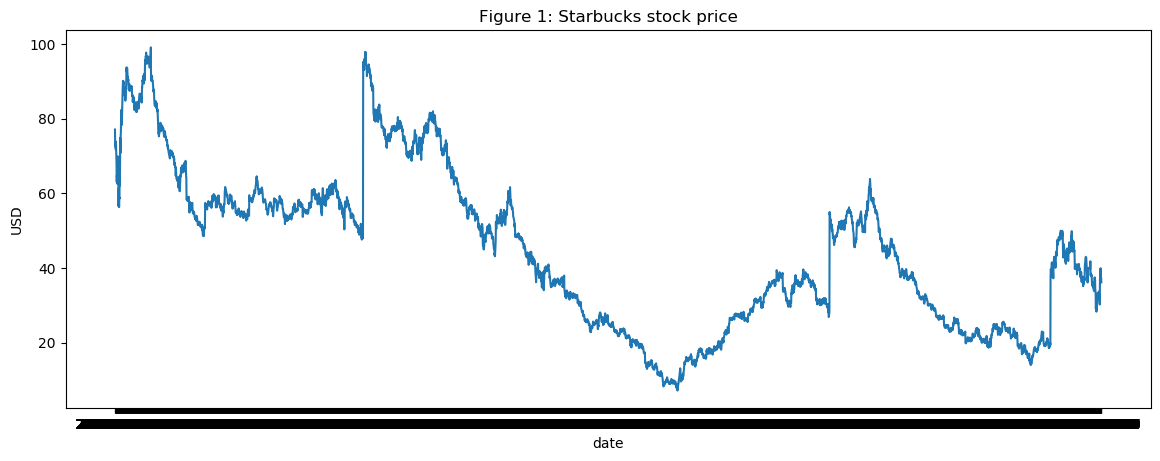

In [5]:
# lets visualize the stock

plt.figure(figsize=(14, 5), dpi=100)
plt.plot(SBUX['date'], SBUX['4. close'], label='Starbucks stock')
plt.xlabel('date')
plt.ylabel('USD')
plt.title('Figure 1: Starbucks stock price')
plt.show()

## Correlated Assets

As explained earlier, I will use other assets as features, not only SBUX.

What other assets would affect SBUX stock movements? Good understanding of the company, it's lines of business, competitive landscape, dependencies, suppliers and client type, etc, is very important for picking the right set of correlated assets:
1. First are the companies similar to SBUX. I will add Dunkin Donuts, Panera, Lavazza and others to the dataset. 
2. As a coffee shop, Starbucks depends on the global economy. Bad or volatile economy means less tourism related purchases and work day purchases. This is why I will include global economy indices.
3. Daily volatility index (**VIX**) - for the reason described above
4. **Composite Indices** - such as NASDAQ and NYSE,FTSE100 (UK), Nikkei225 (Japan), Hang Seng and BSE Sensex (APAC) indices
5. **Currencies** - global trade is many times reflected into how currencies move, ergo I'll use a basket of currencyes as features. Currencies from supplier countreis and countries with many stores. 

## Technical Indicators

In [7]:
# function only works with the Alpha Vantage data 'Timeseries'
def get_technical_indicators(dataset):
    #create 7 and 21 days moving average
    dataset['ma7'] = dataset['4. close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['4. close'].rolling(window=21).mean()
    
    #create MACD
    dataset['26ema'] = pd.ewma(dataset['4. close'],span=26)
    dataset['12ema'] = pd.ewma(dataset['4. close'], span=12)
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
    
    #create Bollinger Bands
    dataset['20sd'] = pd.stats.moments.rolling_std(dataset['4. close'],20)
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    #create exponential moving average
    dataset['ema'] = dataset['price'].ewm(com=0.5).mean()
    
    #create momentum
    dataset['momentum'] = dataset['4. close']-1
    
    return dataset

In [8]:
dataset_TI_SBUX= get_technical_indicators(SBUX)

AttributeError: module 'pandas' has no attribute 'ewma'

# Dictionary

**XGBoost** - optimized distributed boosting library designed to be highly efficient, flexible, and portable. Designed to be memory efficient.

**Sklearn.preprocessing** - provides several common utilty fucntions and transformer classes to change raw feature vectors into a represetnation that is more sutiable for the downstream estimators. Learning algorithms benefit from the standaradization of data sets. 

**Sklearn.metrics** - includes score functions, performance metrics and pairwase metrics and distance computations

**Mxnet** - Apache deep learning framework designed for both efficiency and flexibility. It allows you to mic the flavours of deep learning programs together to maximize the efficiency and your productivity. The Python API has two primary high-level packages: the Gluon API and Module API. 

**8 and 21 Day Moving Average** - Help figure out: whether I want to be in a Portfolio Approach or Tactical Approach, which stocks I want to be long or short, the strength of the current market trend. Average of a stocks daily closing price. 

**Exponential Moving Average** - Gives recent prices a bigger weight, so it does a better job of measuring recent momentum. An object in motion stays in motion, supposedly. 

**Bollinger Bands** - a technical analysis tool defined by a set of lines plotted two standard deviations(positvely and negatively) away from a simple moving average (SMA) of the security's price. They bracket the 20-day SMA of the stock with an upper and lower band along wit hthe daily movements of the stocks price. 

**MACD** - Is a trend following momentum indicator that shows the relationship between two moving averages of a security's price. Calculated by subtracting the 26-period exponential moving average (EMA) from the 12-period EMA. 

**Fourier Transforms** - decomposes a function into it's constituent frequencies. Transformation from the time domain to the frequency domain. All waves can be viewed equally accurately in the time or frequency domain, we have a new way of viewing the world. 

**Autoregressive Integrated Moving Average** - A form of regression analysis that gauges the strength of one dependent varaible relative to other changing variables. The goal is to predict future securities or financial market moves by examining the differences between values in the series instead of through actual values. 

**Heteroskedasticity** - When the standard errors of a variable, monitored over a specific amount of time, are non-constant. The tell-tale sign upon visual inspection of the residual erros is that they will tend to fan out over time. It often arises in two forms: conditional and unconditional. Conditional heteroskedasticity identifies nonconstant volatility when future periods of high and low volatility cannot be identified. Unconditional is used when futures periods of high and low volatility can be identified. 

**Multicollinearity** - The occurence of high intecorrelations among independent variables in a multiple regression model. This can lead to wider confidence intervals and less reliable probability values for the independant variables.

**Serial Correlation** - The relationship between a given variable and a lagged version of itself over various time intervals. In finance, this correlation is used by technical analysts to determine how well the past price of a security predicts the future price. aka lagged correlation. 